In [1]:
import numpy as np
import pandas as pd

# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
'''
downloaded = drive.CreateFile({'id':'1fjM5LTtbHpkeI0CxnuMWWc0vC3_ldhw-'}) 
downloaded.GetContentFile('quora_questions.csv') 

quora= pd.read_csv("quora_questions.csv")

quora.head()

'''

'\ndownloaded = drive.CreateFile({\'id\':\'1fjM5LTtbHpkeI0CxnuMWWc0vC3_ldhw-\'}) \ndownloaded.GetContentFile(\'quora_questions.csv\') \n\nquora= pd.read_csv("quora_questions.csv")\n\nquora.head()\n\n'

# Question and Answer Chat Bots

## Loading the Data

We will be working with the Babi Data Set from Facebook Research.

Full Details: https://research.fb.com/downloads/babi/

- Jason Weston, Antoine Bordes, Sumit Chopra, Tomas Mikolov, Alexander M. Rush,
  "Towards AI-Complete Question Answering: A Set of Prerequisite Toy Tasks",
  http://arxiv.org/abs/1502.05698


In [3]:
downloaded = drive.CreateFile({'id':'1A7O67NVUsahGvcv497TdnD9LFk5BvDDI'}) 
downloaded.GetContentFile('train_qa.txt') 

downloaded = drive.CreateFile({'id':'1_G9c3NGMzENi1VGrInCZmOilAafFUhhE'}) 
downloaded.GetContentFile('test_qa.txt') 

In [4]:
import pickle
import numpy as np


with open("train_qa.txt", "rb") as fp:   # Unpickling
    train_data =  pickle.load(fp)

with open("test_qa.txt", "rb") as fp:   # Unpickling
    test_data =  pickle.load(fp)

In [5]:
type(test_data)

list

In [6]:
type(train_data)

list

In [7]:
len(test_data)

1000

In [8]:
len(train_data)

10000

In [9]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [10]:
' '.join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [11]:
' '.join(train_data[0][1])

'Is Sandra in the hallway ?'

In [12]:
train_data[0][2]

'no'

-----

## Setting up Vocabulary of All Words

In [13]:
# Create a set that holds the vocab words
vocab = set()

In [14]:
all_data = test_data + train_data

In [66]:
len(all_data)

11000

A set in python is an unordered collection of unique elements

In [15]:
for story, question , answer in all_data:
    # In case you don't know what a union of sets is:
    # https://www.programiz.com/python-programming/methods/set/union
    # set of story is: set(train_data[0]0)
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [16]:
vocab.add('no')
vocab.add('yes')
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [17]:
vocab_len = len(vocab) + 1 #we add an extra space to hold a 0 for Keras's pad_sequences

In [18]:
max_story_len = max([len(data[0]) for data in all_data])
max_story_len

156

In [19]:
max_question_len = max([len(data[1]) for data in all_data]) # index for story is "1"

In [20]:
max_question_len

6

## Vectorizing the Data

In [21]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [22]:
# Reserve 0 for pad_sequences
vocab_size = len(vocab) + 1

In [23]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# integer encode sequences of words
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

tokenizer.word_index

Using TensorFlow backend.


{'.': 8,
 '?': 37,
 'apple': 18,
 'back': 14,
 'bathroom': 12,
 'bedroom': 19,
 'daniel': 6,
 'discarded': 2,
 'down': 15,
 'dropped': 29,
 'football': 27,
 'garden': 10,
 'got': 33,
 'grabbed': 20,
 'hallway': 4,
 'in': 32,
 'is': 26,
 'john': 7,
 'journeyed': 31,
 'kitchen': 17,
 'left': 25,
 'mary': 36,
 'milk': 1,
 'moved': 16,
 'no': 9,
 'office': 28,
 'picked': 3,
 'put': 11,
 'sandra': 13,
 'the': 24,
 'there': 21,
 'to': 35,
 'took': 23,
 'travelled': 22,
 'up': 5,
 'went': 34,
 'yes': 30}

In [24]:
train_story_text = []
train_question_text = []
train_answers = []

for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)

In [25]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [26]:
print (len(train_story_text))
print (len(train_story_seq))

10000
10000


In [27]:
# word_index = tokenizer.word_index

### Functionalize Vectorization

In [28]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len,max_question_len=max_question_len):
    '''
    INPUT: 
    
    data: consisting of Stories,Queries,and Answers
    word_index: word index dictionary from tokenizer
    max_story_len: the length of the longest story (used for pad_sequences function)
    max_question_len: length of the longest question (used for pad_sequences function)


    OUTPUT:
    
    Vectorizes the stories,questions, and answers into padded sequences. We first loop for every story, query , and
    answer in the data. Then we convert the raw words to an word index value. Then we append each set to their appropriate
    output list. Then once we have converted the words to numbers, we pad the sequences so they are all of equal length.
    
    Returns this in the form of a tuple (X,Xq,Y) (padded based on max lengths)

    Padding is necessary  to cut down a story if it is too long and stories to have same padding
    '''
    
    
    # X = STORIES
    X = []
    # Xq = QUERY/QUESTION
    Xq = []
    # Y = CORRECT ANSWER
    Y = []
    
    
    for story, query, answer in data:
        
        # Grab the word index for every word in story
        x = [word_index[word.lower()] for word in story]
        # Grab the word index for every word in query
        xq = [word_index[word.lower()] for word in query]
        
        # Grab the Answers (either Yes/No so we don't need to use list comprehension here)
        # Index 0 is reserved so we're going to use + 1
        y = np.zeros(len(word_index) + 1)
        
        # Now that y is all zeros and we know its just Yes/No , we can use numpy logic to create this assignment
        #
        y[word_index[answer]] = 1
        
        # Append each set of story,query, and answer to their respective holding lists
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    # Finally, pad the sequences based on their max length so the RNN can be trained on uniformly long sequences.
        
    # RETURN TUPLE FOR UNPACKING
    return (pad_sequences(X, maxlen=max_story_len),pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [29]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [30]:
inputs_test

array([[ 0,  0,  0, ..., 24, 19,  8],
       [ 0,  0,  0, ..., 24, 10,  8],
       [ 0,  0,  0, ..., 24, 10,  8],
       ...,
       [ 0,  0,  0, ..., 24, 18,  8],
       [ 0,  0,  0, ..., 24, 10,  8],
       [ 0,  0,  0, ..., 18, 21,  8]], dtype=int32)

In [31]:
queries_test

array([[26,  7, 32, 24, 17, 37],
       [26,  7, 32, 24, 17, 37],
       [26,  7, 32, 24, 10, 37],
       ...,
       [26, 36, 32, 24, 19, 37],
       [26, 13, 32, 24, 10, 37],
       [26, 36, 32, 24, 10, 37]], dtype=int32)

In [32]:
answers_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
sum(answers_test)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 503.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 497.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.])

In [34]:
tokenizer.word_index['yes']

30

In [35]:
tokenizer.word_index['no']

9

## Creating the Model

In [36]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM

### Placeholders for Inputs

Recall we technically have two inputs, stories and questions. So we need to use placeholders. `Input()` is used to instantiate a Keras tensor.


In [37]:
# placeholder shape= (max_story_len, batch_size)

input_sequence = Input((max_story_len,)) # the input shape is a tuple 
question = Input((max_question_len,))

### Building the Networks

To understand why we chose this setup, make sure to read the paper we are using:

* Sainbayar Sukhbaatar, Arthur Szlam, Jason Weston, Rob Fergus,
  "End-To-End Memory Networks",
  http://arxiv.org/abs/1503.08895

## Encoders

### Input Encoder m

In [38]:
# Input gets embedded to a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64)) # output dimensions from the paper= 64
input_encoder_m.add(Dropout(0.3))

# This encoder will output:
# (samples, story_maxlen, embedding_dim)

In [39]:
# Input Encoder c

# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))
# output: (samples, story_maxlen, query_maxlen)

In [40]:
# Question Encoder

# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=max_question_len))
question_encoder.add(Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)

In [41]:
# Encode the Sequences

# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [42]:
# Use dot product to compute the match between first input vector seq and the query
# shape: `(samples, story_maxlen, query_maxlen)`
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)


In [43]:
# Add this match matrix with the second input vector sequence

# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

In [44]:
# concatenate

# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])
answer

<tf.Tensor 'concatenate_1/concat:0' shape=(None, 6, 220) dtype=float32>

In [45]:
# Reduce with RNN (LSTM)
answer = LSTM(32)(answer)  # (samples, 32)

In [46]:
# Regularization with Dropout
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)

In [47]:
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       multiple             2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
____________________________________________________________________________________________

In [49]:
# train
history = model.fit([inputs_train, queries_train], answers_train,batch_size=32,epochs=10,validation_data=([inputs_test, queries_test], answers_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 10000 samples, validate on 1000 samples
Epoch 1/10
10000/10000 [==============================] - 6s 569us/step - loss: 0.9399 - accuracy: 0.4837 - val_loss: 0.7007 - val_accuracy: 0.4970
Epoch 2/10
10000/10000 [==============================] - 5s 469us/step - loss: 0.7052 - accuracy: 0.5038 - val_loss: 0.6935 - val_accuracy: 0.5030
Epoch 3/10
10000/10000 [==============================] - 5s 467us/step - loss: 0.6972 - accuracy: 0.4890 - val_loss: 0.6936 - val_accuracy: 0.5030
Epoch 4/10
10000/10000 [==============================] - 5s 471us/step - loss: 0.6955 - accuracy: 0.4908 - val_loss: 0.6931 - val_accuracy: 0.5030
Epoch 5/10
10000/10000 [==============================] - 5s 469us/step - loss: 0.6951 - accuracy: 0.4944 - val_loss: 0.6933 - val_accuracy: 0.4970
Epoch 6/10
10000/10000 [==============================] - 5s 472us/step - loss: 0.6944 - accuracy: 0.5031 - val_loss: 0.6945 - val_accuracy: 0.5030
Epoch 7/10
10000/10000 [==============================] - 5s 47

In [50]:
### Saving the Model

filename = 'chatbot_120_epochs.h5'
model.save(filename)

## Evaluating the Model

### Plotting Out Training History

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


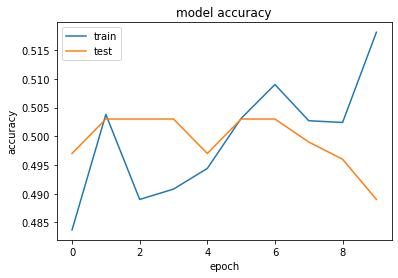

In [51]:


import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Evaluating on Given Test Set

In [52]:
model.load_weights(filename)
pred_results = model.predict(([inputs_test, queries_test]))

In [53]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [54]:
story =' '.join(word for word in test_data[0][0])
print(story)

Mary got the milk there . John moved to the bedroom .


In [55]:
query = ' '.join(word for word in test_data[0][1])
print(query)

Is John in the kitchen ?


In [56]:
print("True Test Answer from Data is:",test_data[0][2])

True Test Answer from Data is: no


In [57]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  yes
Probability of certainty was:  0.50451785


## Writing Your Own Stories and Questions

Remember you can only use words from the existing vocab

In [58]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [59]:
# Note the whitespace of the periods
my_story = "John left the kitchen . Sandra dropped the football in the garden ."
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [60]:
my_question = "Is the football in the garden ?"

In [61]:
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [62]:
mydata = [(my_story.split(),my_question.split(),'yes')]

In [63]:
my_story,my_ques,my_ans = vectorize_stories(mydata)

In [64]:
pred_results = model.predict(([ my_story, my_ques]))

In [65]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.5019536
